In [1]:
import os
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp
from jax import vmap, jit
import numpyro.distributions as dist
from einops import rearrange, repeat
from scipy.stats import multivariate_normal

%load_ext autoreload
%autoreload 2

In [2]:
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import interp
from gigalens.jax.profiles.mass import shear, sie, field

In [3]:
# Color maps for main and residual plots
cmap = 'magma'
cmap_resid = 'RdGy'

## Configuration

In [4]:
data_dir = "../data/"

In [5]:
## Image configuration

image_extent = 5  # Size of image in arcmin
n_xy = 100  # Number of pixels

n_sup = 1  # Supersampling of source factor during fitting
n_xy_s = int(n_sup * n_xy)

fwhm_psf = 0.005  # ELT FWHM of 5 mas from 1903.04742

In [6]:
lens_conf_idx = 0  # Whether to use lens configuration 0 or 1 (see below)

In [7]:
## MLP configuration

num_dense_layers = 4
dense_layer_width = 256
add_positional_encoding = False
positional_encoding_dims = 5
add_random_fourier = True
bandwidth_rff = 5.
add_skip_connection = False

In [8]:
## RNG; set to fixed values for deterministic run
key_model = 42  # np.random.randint(1000)
key_train = 43  # np.random.randint(1000)

In [9]:
## Training configuration

n_q_samples = 64  # Number of MC samples used to build ELBO expectation

learning_rate_init = 1e-3
learning_rate_variational = 1e-3
weight_decay = 1e-4
momentum = 0.5

train_epochs = 15000
warmup_steps = 0
plot_every = 200

## Source image

In [10]:
from PIL import Image
from skimage.transform import resize
from urllib import request

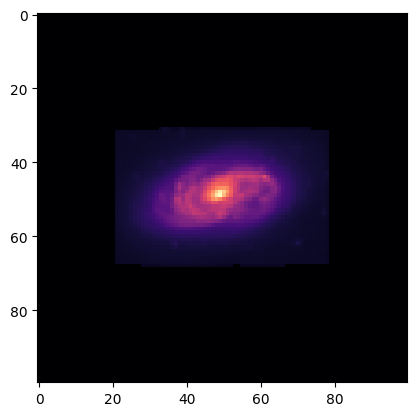

In [11]:
galaxy_url = "https://cdn.spacetelescope.org/archives/images/large/potw2015a.jpg"
galaxy_name = "NGC2906"

# galaxy_url = "https://cdn.spacetelescope.org/archives/images/large/opo0501a.jpg"
# galaxy_name = "NGC1300"

# galaxy_url = "https://cdn.spacetelescope.org/archives/images/large/potw1801a.jpg"
# galaxy_name = "UGC6093"

if not os.path.exists("{}/galaxy_images/{}.jpg".format(data_dir, galaxy_name)):
    request.urlretrieve(galaxy_url, "{}/galaxy_images/{}.jpg".format(data_dir, galaxy_name))

im_source = np.asarray(Image.open("{}/galaxy_images/{}.jpg".format(data_dir, galaxy_name)).convert('L'))

im_source_temp = np.zeros((np.max(im_source.shape), np.max(im_source.shape)))
im_source_temp[int(im_source.shape[1] / 2 - im_source.shape[0] / 2):int(im_source.shape[1] / 2 + im_source.shape[0] / 2), :] = im_source
im_source = im_source_temp
im_source = im_source - np.min(im_source)
im_source = im_source / np.max(im_source)
if galaxy_name == "NGC1300":
    im_source = np.pad(im_source, (1920, 1920))
elif galaxy_name == "UGC6093":
    im_source = np.pad(im_source, (640, 640))
else:
    im_source = np.pad(im_source, (1024, 1024))
im_source = resize(im_source, (n_xy_s, n_xy_s), anti_aliasing=True)
im_source[im_source < 0.05] = 0.
plt.imshow(im_source , cmap=cmap)


## Lensed image

In [12]:
sigma_psf = fwhm_psf / 2 ** 1.5 * np.sqrt(np.log(2))  # Convert FWHM to standard deviation

In [13]:
## Make Gaussian PSF kernel

delta_pix = image_extent / n_xy

x_kern = np.linspace(-6, 6, 13)
x, y = np.meshgrid(x_kern, x_kern)
kernel = multivariate_normal(mean=np.zeros(2), cov=np.ones(2) * sigma_psf / delta_pix).pdf(np.dstack((x, y)))
kernel /= np.sum(kernel)

# plt.imshow(kernel)

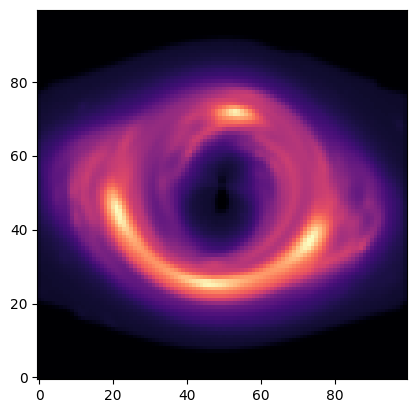

In [14]:
## Lensed image

# Supersample to reduce artifacting
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=n_xy_s, supersample=8, kernel=kernel)
coord_half = sim_config.delta_pix * sim_config.num_pix / 2
x_lims = [-coord_half, coord_half]
y_lims = [-coord_half, coord_half]
phys_model = PhysicalModel([sie.SIE(), shear.Shear()], [], [interp.Interp()])

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

if lens_conf_idx == 0:
    truth = [[
        {'theta_E': 1.3, 'e1': 0.2, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.0},
        {'gamma1': -0.02, 'gamma2': 0.02}
    ], [ 
        {'img': im_source, 'x_lims': x_lims, 'y_lims': y_lims}
    ]]
elif lens_conf_idx == 1:
    truth = [[
        {'theta_E': 1.1, 'e1': 0.1, 'e2': 0.15, 'center_x': 0.4, 'center_y': -0.1},
        {'gamma1': -0.03, 'gamma2': 0.04}
    ], [ 
        {'img': im_source, 'x_lims': x_lims, 'y_lims': y_lims}
    ]]
else:
    raise NotImplementedError
    
std_noise = 1.e-6
image = lens_sim.simulate(truth)
image += std_noise * np.random.randn(*image.shape)
image = image.reshape(-1, n_sup, image.shape[-1] // n_sup, n_sup).sum((-1, -3))

# Revert supersampling configuration for forward simulator
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=n_xy_s, supersample=1, kernel=kernel)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

plt.imshow(image.T, origin='lower' , cmap=cmap)

In [19]:
# Compute SNR around lens
np.median(image[image > 0.5 * image.max()] / std_noise)

1110.5221

In [20]:
# Compute max SNR
image.max() / std_noise

Array(1886.5697, dtype=float32)

In [40]:
def rho(x,y):
    return 1 / (x ** 2 + y ** 2)

In [38]:
jax.jacfwd(rho, argnums=(0,1))(jnp.array([7.,5.]), jnp.array([1.,5.]))

(Array([[-0.0056, -0.    ],
        [-0.    , -0.004 ]], dtype=float32),
 Array([[-0.0008, -0.    ],
        [-0.    , -0.004 ]], dtype=float32))

In [41]:
jax.grad(rho, argnums=(0,1))(1., 5.)

(Array(-0.00295858, dtype=float32, weak_type=True),
 Array(-0.0147929, dtype=float32, weak_type=True))

In [48]:
jax.vmap(jax.grad(rho, argnums=(0,1)), in_axes=((0,1), (0,1)))(jnp.array([[7.,5.],[7.,5.]]), jnp.array([[1.,5.],[7.,5.]]))

ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification ((0, 1), (0, 1)) for value tree PyTreeDef((*, *)).

In [31]:
## Lensed image

# Supersample to reduce artifacting
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=n_xy_s, supersample=8, kernel=kernel)
coord_half = sim_config.delta_pix * sim_config.num_pix / 2
x_lims = [-coord_half, coord_half]
y_lims = [-coord_half, coord_half]
phys_model = PhysicalModel([field.FIELD(), shear.Shear()], [], [interp.Interp()])

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

truth = [[
    {'img': im_source, 'x_lims': x_lims, 'y_lims': y_lims},
    {'gamma1': -0.02, 'gamma2': 0.02}
], [ 
    {'img': im_source, 'x_lims': x_lims, 'y_lims': y_lims}
]]
    
std_noise = 1.e-6
image = lens_sim.simulate(truth)
image += std_noise * np.random.randn(*image.shape)
image = image.reshape(-1, n_sup, image.shape[-1] // n_sup, n_sup).sum((-1, -3))

# Revert supersampling configuration for forward simulator
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=n_xy_s, supersample=1, kernel=kernel)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

plt.imshow(image.T, origin='lower' , cmap=cmap)

(800, 800, 1) (800, 800, 1)
(800, 800, 800, 800, 1) (800, 800, 800, 800, 1)


TypeError: transpose permutation isn't a permutation of operand dimensions, got permutation (2, 0, 1) for operand shape (800, 800, 800, 800, 1).

## Lensed image rendering function wrapper

In [17]:
def render_lens(inputs):
    
    samples_src, samples_lens_params, x_lims, y_lims = inputs
    
    theta_E, theta_x, theta_y, e_1, e_2, gamma_1, gamma_2 = samples_lens_params
    
    truth = [[
        {'theta_E': theta_E, 'e1': e_1, 'e2': e_2, 'center_x': theta_x, 'center_y': theta_y},
        {'gamma1': gamma_1, 'gamma2': gamma_2}
    ], [ 
        {'img': samples_src, 'x_lims': x_lims, 'y_lims': y_lims}
    ]]

    image = lens_sim.simulate(truth)
    lens_sim.simulate(truth)
    
    return image

In [18]:
render_lens_vmapped = vmap(jit(render_lens))